# _emcee_ et convergence

Au dernier TP, nous avons implémenté un MCMC Metropolis-Hastings nous-mêmes. En pratique, il est généralement plus simple et plus robuste d'utiliser une librairie bien testée et qui permet d'explorer différentes distributions de proposition. Pour le reste du cours, nous ferons les MCMCs avec [_emcee_](https://emcee.readthedocs.io/en/stable/). Par défaut, _emcee_ utilise le _stretch move_ que nous avons vu en classe pour proposer des échantillons.

En plus d'implémenter un échantillonneur (_sampler_), _emcee_ inclut également des fonctions pour vérifier la convergence de nos chaînes. D'ailleurs, les diapositives sur l'autocorrélation sont inspirées par le tutoriel  [Autocorrelation analysis & convergence](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/) d'_emcee_.

Dans ce TP, nous allons apprendre à utiliser _emcee voir en pratique comment certains facteurs affectent la convergence. Nous utiliserons la fonction `get_autocorr_time()` d'_emcee_ pour calculer le temps d'autocorrélation de nos chaînes. Cette fonction nous avertira également si nos chaînes sont moins longues que 50 fois la valeur estimée du temps d'autocorrélation.


Plan:
1. [MCMC appliqué à l'analyse de données](#section-1)
1. [Distributions de proposition et convergence](#section-2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import corner
import emcee

In [2]:
rcParams["font.size"] = 18
rcParams["figure.figsize"] = (9, 6)
rcParams["xtick.direction"] = "in"
rcParams["ytick.right"] = True

<a id="section-1"></a>
## 1 - MCMC appliqué à l'analyse de données

Dans cette section, nous allons appliquer _emcee_ pour modéliser un signal périodique.

### Données synthétiques et vraisemblance maximale

Les première étapes consistent à générer des données synthétiques autour d'une droite, à estimer les paramètres ayant une vraisemblance (sans les _priors_) maximale et à les utiliser comme point de départ dans un MCMC qui échantillone la distribution à posteriori.

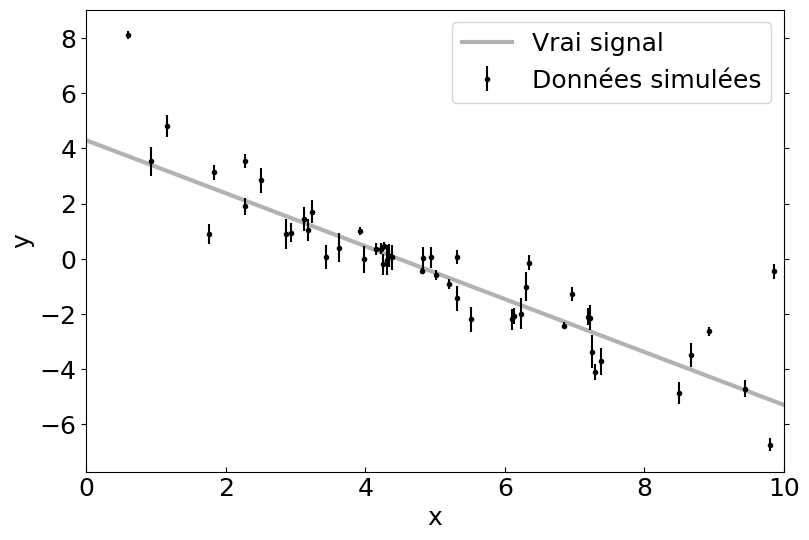

In [55]:
# Cette cellulle est tirée du tutoriel emcee pour obtenir exactement les mêmes données
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="Données simulées")
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="Vrai signal")
plt.legend()
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Nous aurons besoin de la fonction de vraisemblance pour le premier estimé. Elle pourra être réutilisée plus tard pour définir la distribution à posteriori.

Notre modèle physique est donné par une droite

$$
f(x) = m x + b.
$$

Nous utiliserons une vraisemblance gaussienne, mais ajouterons un paramètre additionnel au cas où les erreurs aient été sous-estimées, de sorte que la variance totale est donnée par:

$$
s_n^2 = \sigma_n^2 + (m x_n + b)^2 f^2
$$

où $sigma_n^2$ correspond à `yerr` pour chaque point. Il est généralement suggéré d'utiliser un tel facteur ou, encore plus simple, un paramètre $sigma^2$ tel que $s_n^2 = \sigma_n^2 + \sigma^2$ pour s'assurer que les barres d'erreur ne sont pas sous-estimées. Si elles ne l'étaient pas, le paramètre convergera simplement vers 0.

In [56]:
def log_likelihood(theta, x, y, yerr):
    """
    - theta: vecteur de paramètres m, b et log_f
    - x, y, yerr: données
    """
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)  # Variance avec un facteur multiplicatif
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))  # Vraisemblance gaussienne (en log)

Maximum likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


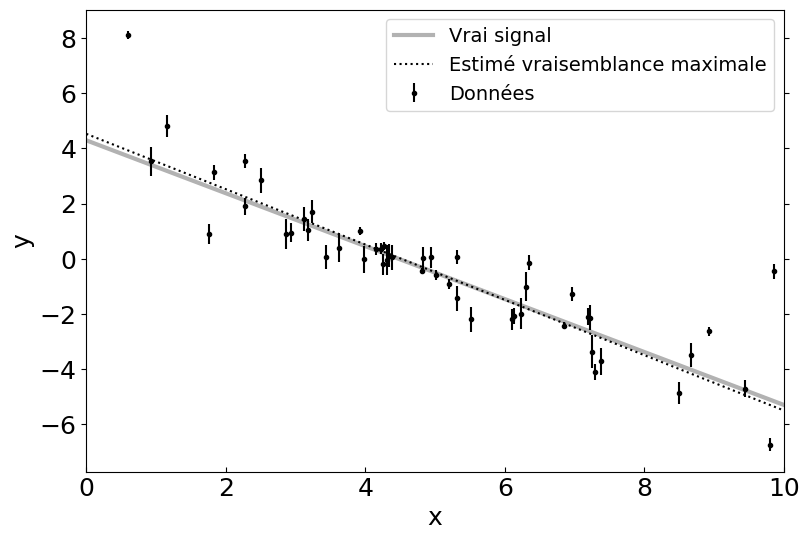

In [57]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label="Données")
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="Vrai signal")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="Estimé vraisemblance maximale")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

On peut voir que le modèle de vraisemblance maximale est déjà en bon accord avec le la vraie droite. Par contre, il n'y a pas de barres d'erreurs sur nos paramètres et nous n'avons specifiés aucuns _priors_.

### Exemple initial de MCMC

On peut d'abord reproduire l'exemple _emcee_ avec les mêmes _priors_ pour s'assurer que tout fonctionne comme prévu.
On implémente tout en espace log, car c'est ce qu'utilise _emcee_, pour les raison numériques dont nous avons discuté en classe.

Remarquez qu'on ne calcule pas le _likelihood_ si le _prior_ est 0 (log-prior $ = -\infty$), pour sauver du temps de calcul.

In [58]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

On peut maintenant échantilloner avec _emcee_. Quelques points importants:

- _emcee_ échantillonne en parallèle avec plusieurs chaînes (32 ici).
- On doit donc initialiser des "marcheurs" dans un tableau avec 32 positions aléatoires pour chacun de nos 3 paramètres.
- Pour l'initialisation, généralement, une petite "balle" gaussienne suffit. Les marcheurs vont s'étendre à l'espace des paramètres assez rapidement.
- Il y a une phase de _burn in_ ou _warm-up_ au début qui permet aux marcheurs de trouver l'ensemble typique du _posterior_.

In [60]:
import emcee

# Initialisation des marcheurs autour du point Max-likelihood
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

# MCMC:
# - Il faut donner à emcee le nombre de marcheurs et de paramètres pour son objet "sampler".
# - Il faut aussi donner la fonction log-posterior ainsi qu'ajouter les arguments autres que les paramètres
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
# Ensuite, le sampler peut faire un MCMC à partir d'une position initiale
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1192.26it/s]


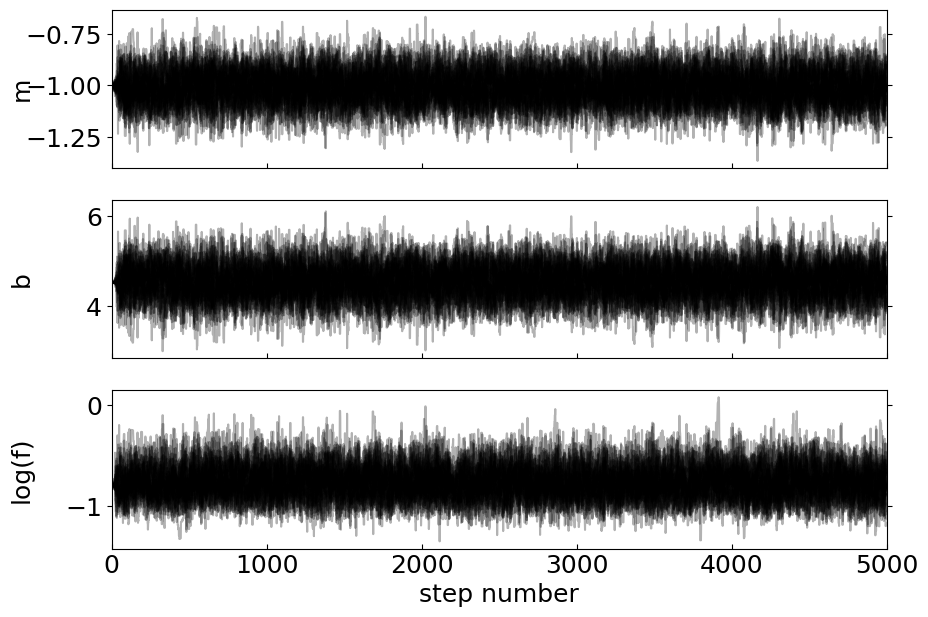

In [61]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

On peut voir que les chaînes semblent bien échantillonner les paramètres à premières vue. Il y a une petite période de rodage ("_burn-in_") au début qui devra être coupée avant nos analyses finales.

Mais avant, on peut vérifier la convergence plus quantitativement en s'assurant que le temps d'autocorrélation intégré est inférieur à la longueur de la chaîne divisée par 50. Si ce n'est pas le cas, _emcee_ affichera une erreur.

In [62]:
# On jette les 100 premiers échantillons pour le burn-in
tau = sampler.get_autocorr_time(discard=100)
print(f"Temps d'autocorrélation intégrés: {tau}")

Temps d'autocorrélation intégrés: [36.39596231 36.42809395 36.23576976]


Le temps d'autocorrélation est donné pour chaque paramètre. Donc on peut voir quels paramètres convergent plus ou moins facilement.

On peut maintenant faire un _corner plot_ pour afficher la distribution marginalisées 1D des paramètres et les distributions 2D pour voir s'il y a des covariances.

In [63]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

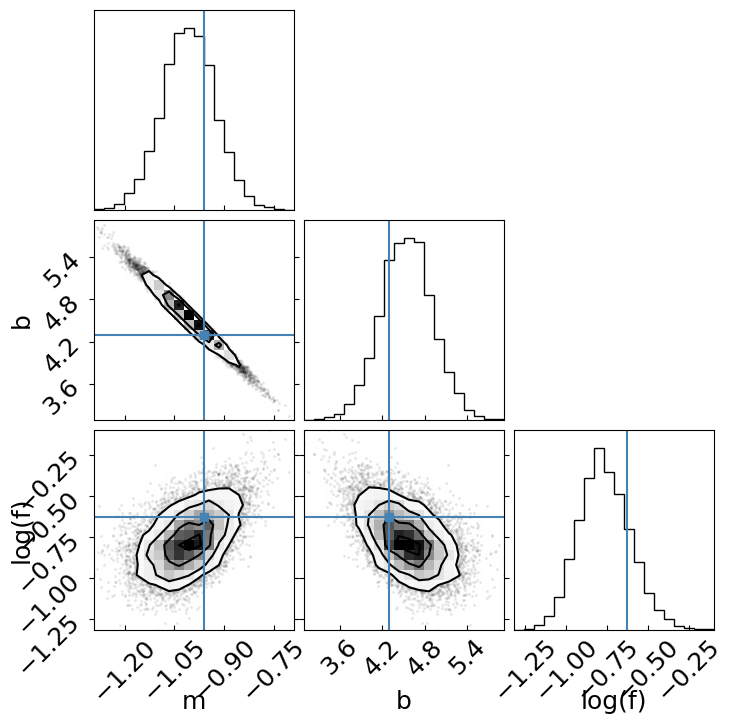

In [64]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)
plt.show()

On peut voir que $m$ et $b$ sont fortement anti-corrélés. Un changement dans l'un affectera fortement l'autre dans le MCMC et dans la solution finale

Pour bien vérifier que le modèle correspond aux données, on peut également afficher des échantillons du MCMC superposés aux données.

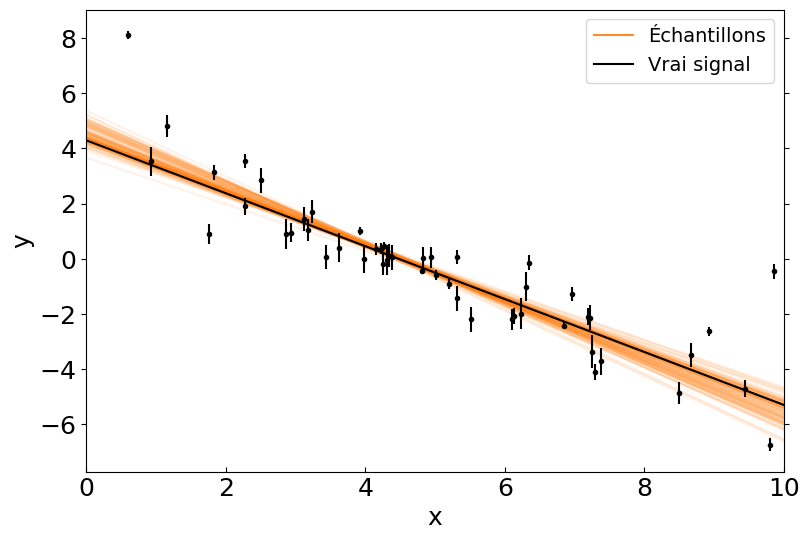

In [65]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.9 if ind == inds[0] else 0.1, label="Échantillons" if ind == inds[0] else None)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="Vrai signal")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

### Effet de la longueur des chaines

Si on répète le processus, mais qu'on s'arrête avec des chaînes trop courtes, l'échantillonage sera incomplet. _emcee_ nous le laissera savoir lorsqu'on calcule le temps d'autocorrélation, mais l'inspection visuelle nous aidera aussi.

In [66]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 500, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1168.76it/s]


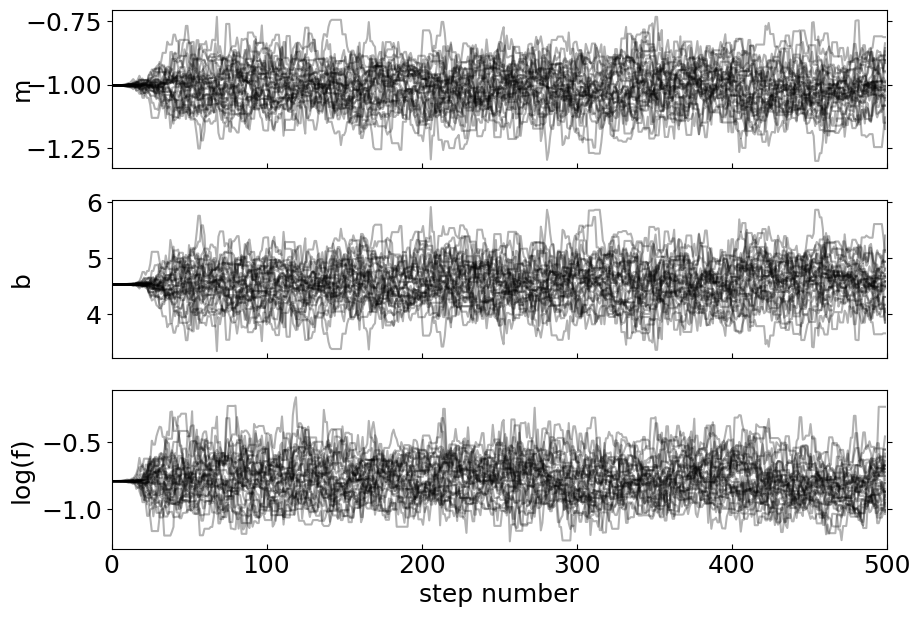

In [67]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [68]:
tau = sampler.get_autocorr_time(quiet=True, discard=100)
print(tau)

N/50 = 8;
tau: [18.53630613 18.86359264 18.09988464]


[18.53630613 18.86359264 18.09988464]


Ici, on peut utiliser l'option `quiet=True` pour avoir un avertissemment au lieu d'une erreur. Le fait que l'on puisse distinguer des variations claires dans les chaînes sur une échelle inférieure à ~ 1/50 de notre chaîne est un autre indicateur (quoique beaucoup moins rigoureux).

Dans ce cas-ci, nous aurions donc eu besoin de plus de pas pour atteindre la convergence (mais le MCMC semblait sur la bonne voie).

### Effet de la distribution à priori

La distribution à priori (le _prior_) peut aussi avoir un impact sur la convergence.

#### Prior trop étroit

Un prior trop étroit sur un ou plusieurs paramètres peut restreindre les valeurs explorées et nous mener à sous-estimer les incertitudes. Dans un tel cas, il n'y a pas un problème de convergence à proprement parler, car la distribution peut être bien échantillonée quand même. Le problème est plutôt dans le _choix de distribution_.

Dans l'exemple ci-desssous le _prior_ sur $m$ est entre -1.1 et -0.9.

In [69]:
def log_prior(theta):
    m, b, log_f = theta
    if -1.1 < m < -0.9 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [70]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1261.49it/s]


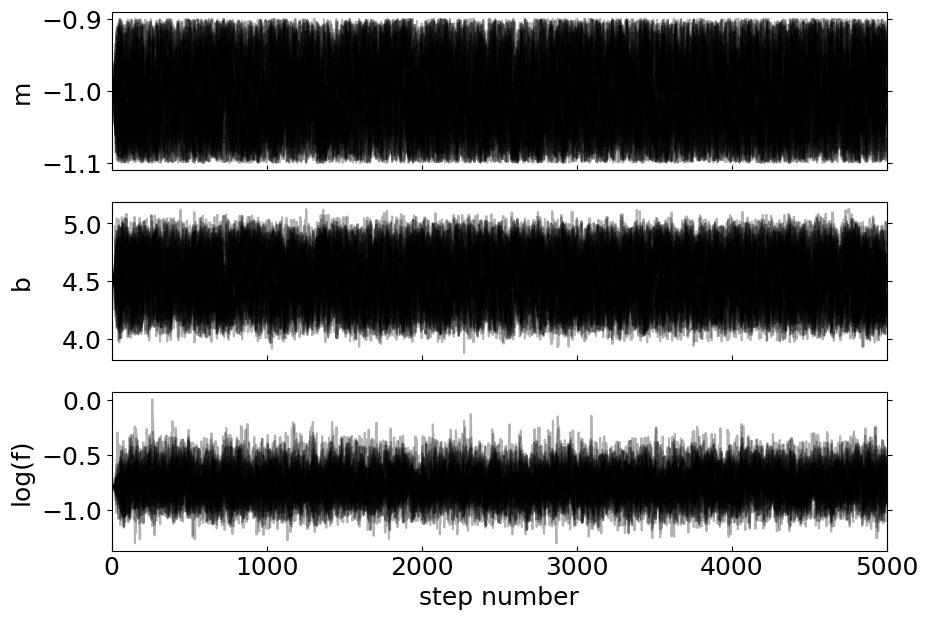

In [71]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [72]:
tau = sampler.get_autocorr_time(quiet=True)
print(tau)

[44.38162195 43.83904933 37.39145537]


Le MCMC semble avoir bien fonctionné si au se fie au temps d'autocorrélation. Par contre, on peut voir que les bords de la chaîne en $m$ sont très droits et bornés aux limites du _prior_...

In [73]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

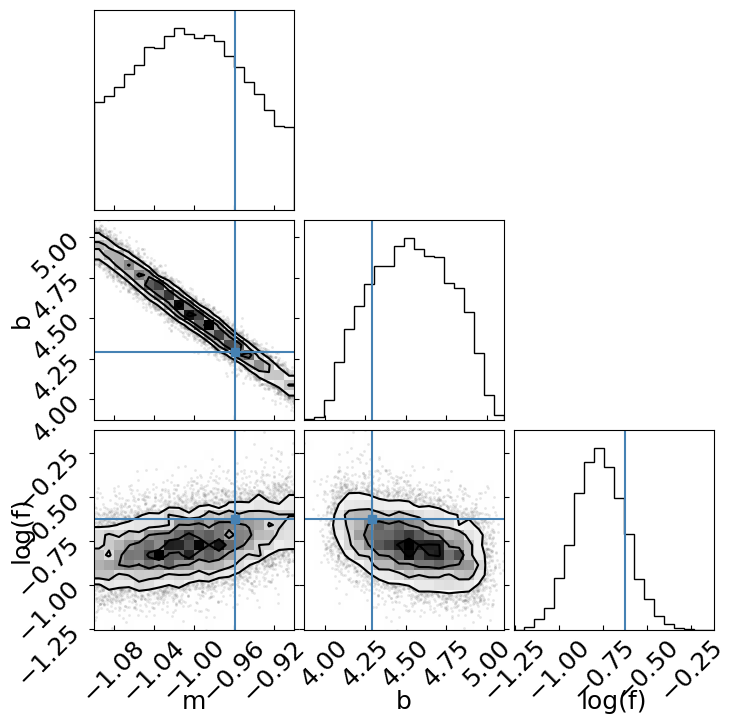

In [74]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)
plt.show()

L'effet décrit plus haut est aussi observable ici. Les bords de la distribution en $m$ sont coupés par le prior. A moins d'avoir une bonne raison de forcer le paramètre dans cette intervalle (par exemple une contrainte physique), il serait préférable d'élargir le prior.

On peut aussi remarquer que le paramètre $b$ a lui aussi une forme plus coupée, en raison de la corrélation entre $m$ et $b$ (en limitant $m$, on limite $b$ du même coup).

#### Prior qui exclue la solution

En définissant un prior qui exclue la solution, nous forcerons $m$ vers des valeurs qui ne représentent pas la meilleure solution.

In [75]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < -4.0 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [76]:
import emcee

pos_guess = soln.x.copy()
pos_guess[0] = -4.5  # On adapte notre guess en m
pos = pos_guess + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:04<00:00, 1192.88it/s]


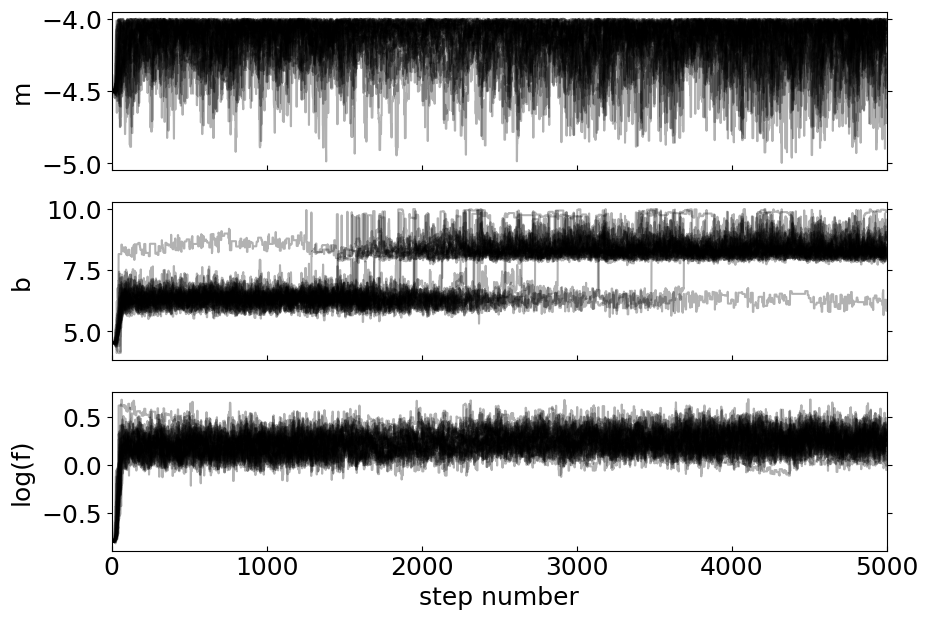

In [77]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [78]:
tau = sampler.get_autocorr_time(quiet=True)
print(tau)

N/50 = 100;
tau: [ 75.71931596 611.90604193 101.53876418]


[ 75.71931596 611.90604193 101.53876418]


On peut voir que la chaîne de $m$ tente de "traverser" le _prior_ mais est limitée à -4.0. $b$ est fortement corrélé avec $m$, et comme la pente de la droite est mal contrainte, $b$ l'est également. $f$ prendra de plus grande valeurs pour compenser ($f$ est une erreur supplémentaire sur le modèle).

Le temps d'autocorrélation est très élevé ici. même 5000 pas ne sont pas suffisant pour fair converger $b$.

In [79]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

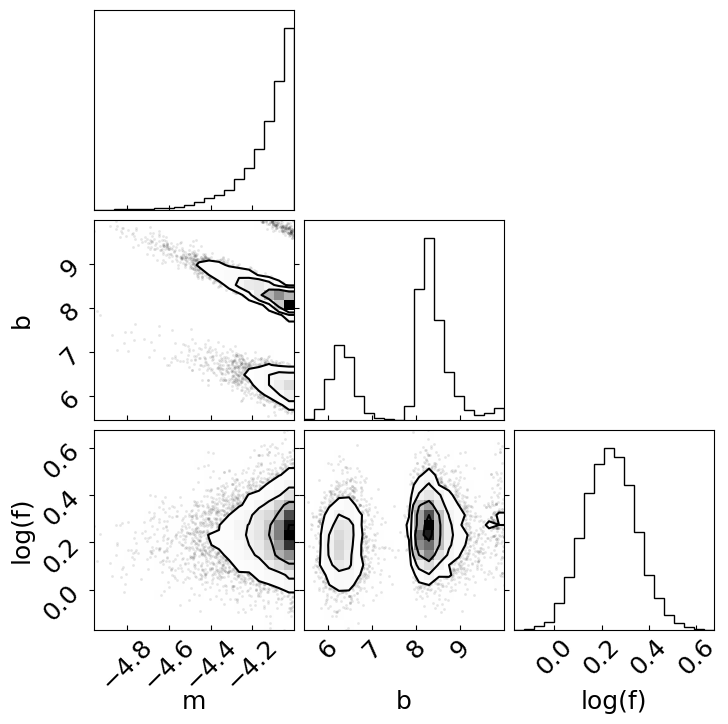

In [80]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)
plt.show()

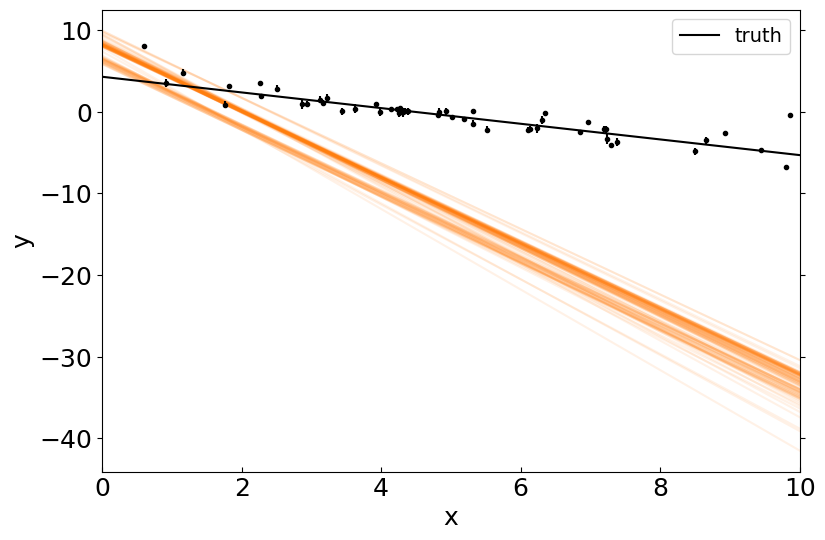

In [81]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Avec les deux graphiques ci-dessus, on voit encore que la pente n'est pas du tout en accord avec les données. Il serait préférable de reconsidérer notre _prior_ pour s'assurer qu'il a du sens physiquement et qu'il permet plus de valeurs en $m$.

### Effet de la position de départ des marcheurs

En changeant la position de départ des marcheurs, la forme des chaînes peut changer. Surtout pendant le _burn-in_. S'il y a des bi-modalités, elles pourraient également être révélées. En général, c'est une bonne idée de répéter le MCMC avec  différentes valeurs initiales pour voir s'il y a toujours une convergence vers la même forme de distribution.

#### Dans le prior, mais plus loin du mode

Dans les sections précédentes, notre initialisation était très près du mode de la distribution. On peut tester des valeurs volontairement plus éloignées pour voir si on retrouve la même solution.

In [82]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [83]:
np.random.seed(666)  # On peut varier/enlever le seed pour voir d'autres formes exactes de la chaîne

pos_guess = [-1.5, 2.0, -1.0]
pos = pos_guess + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

# On peut adapter le nombre de pas selon le nombre requis pour converger (ici 50k prends moins d'une minute).
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 50000, progress=True);

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:43<00:00, 1139.60it/s]


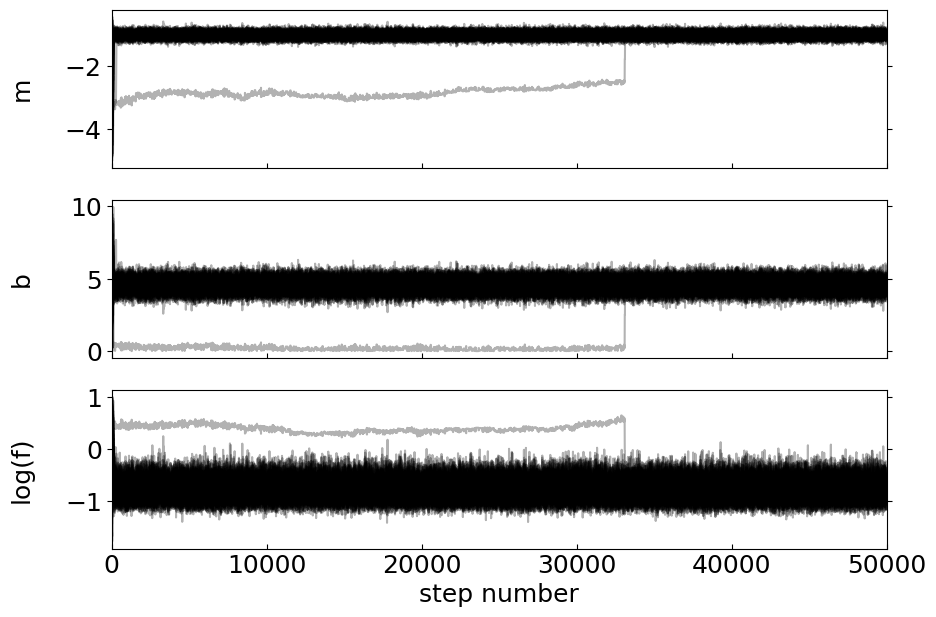

In [84]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

On voit qu'un rodage plus long est en effet nécessaire. Selon les valeurs du germe aléatoire, le pas et de rodage nécessaire peut être très grand (pour `np.random.seed(666)`, il faut environ 35000 pas de rodage pour éviter d'avoir des marcheurs divergents. Par contre, la majorité des cas convergent avec moins de 3000 pas de rodages.

In [85]:
tau = sampler.get_autocorr_time(discard=35000)
print(tau)

[37.5288459  37.31119444 37.49099819]


Avec un rodage suffisant, la chaîne converge tout de même et semble bien échantilloner l'espace de paramètres.

In [86]:
flat_samples = sampler.get_chain(discard=35000, thin=15, flat=True)

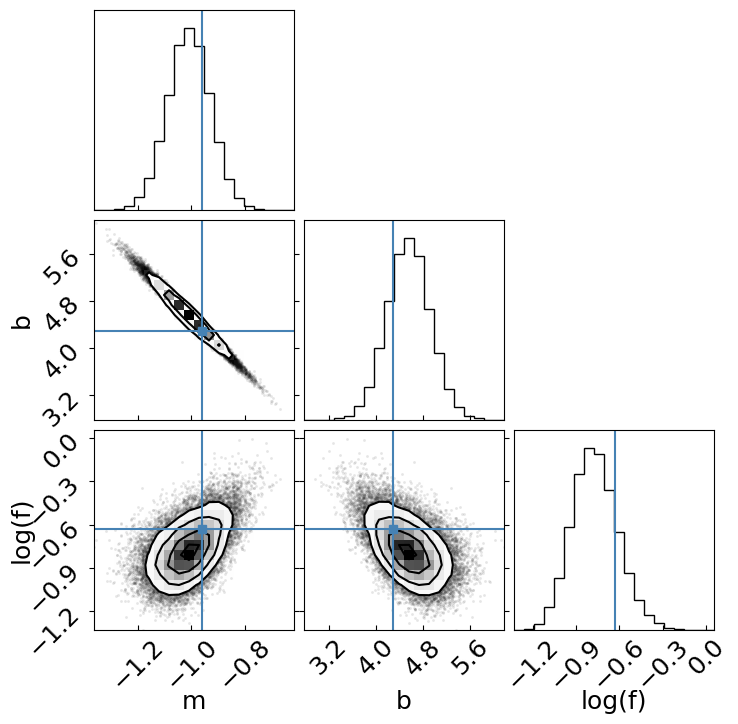

In [87]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)
plt.show()

#### Valeur initiale hors du prior

Il peut arriver, par inattention, qu'on initialise les marcheurs hors du _prior_. C'est habituellement assez facile à identifier.

Quelques exemples de solutions possibles:

- Changer manuellement les valeurs initiales.
- Optimiser le maximum à posteriori (MAP) au lieu de la vraisemblance maximale (ainsi notre valeur initiale tient compte des priors)
- Réviser nos priors, l'erreur pourrait venir d'une borne mal définie et non de la position initiale des marcheurs.
- Ajouter une vérification pour s'assurer que nos valeurs initiales donnent une valeur de _prior_ finie avant de commencer le MCMC (ça ne règle pas le problème, mais ça le détecte plus clairement).

Voici un exemple de macheurs qui démarrent hors du _prior_.

In [88]:
pos_guess = [-10.0, 2.0, -1.0]
pos = pos_guess + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

/home/vandal/miniforge3/envs/phy3051/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract                                                            | 0/5000 [00:00<?, ?it/s]
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 2038.34it/s]


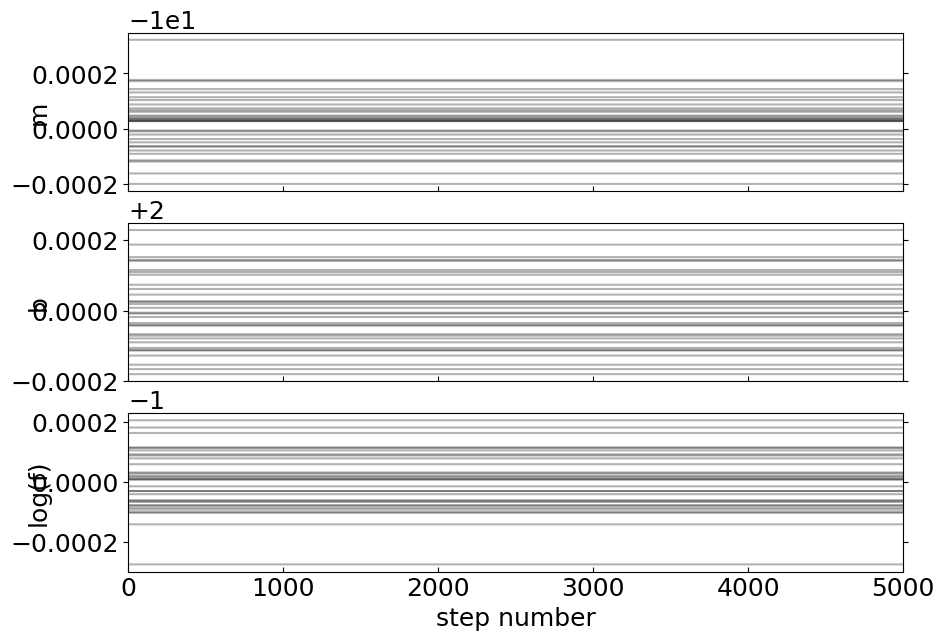

In [89]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [90]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan]


/home/vandal/miniforge3/envs/phy3051/lib/python3.13/site-packages/emcee/autocorr.py:38: RuntimeWarning: invalid value encountered in divide
  acf /= acf[0]


In [91]:
flat_samples = sampler.get_chain(discard=100, flat=True)

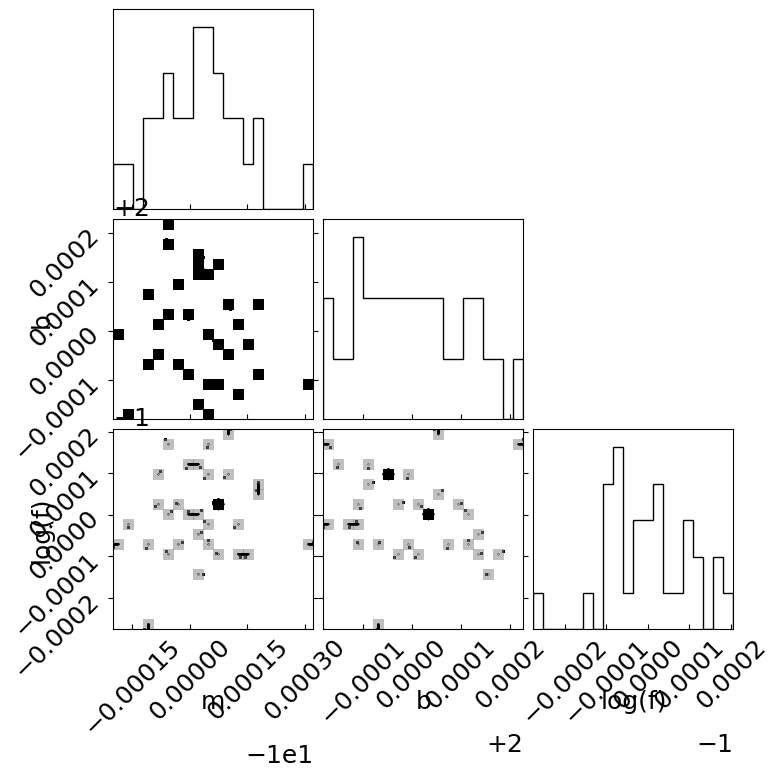

In [92]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
)
plt.show()

Les chaînes sont droites car le _prior_ (et le _posterior_ ensuite) retourne $-\infty$. La probabilité ne change donc jamais et tous les pas sont refusés. Dans un tel cas, l'autocorrélation sera indéfiniie (`nan`). On voit aussi que le _corner plot_ n'affiche pas de distribution claire, mais plus tôt les positions initiales des marcheurs.

<a id="section-2"></a>
## 2 - Distributions de proposition et convergence

Dans la prochaine section, nous explorerons des distributions simples pour voir l'effet de la distribution de proposition (_moves_ dans _emcee_) sur la convergence.

Commençons avec une distribution bimodale en 1D (cette distribution est la même que dans le tutoriel "[Using different moves](https://emcee.readthedocs.io/en/stable/tutorials/moves/)" d'_emcee_). Ici, au lieu d'échantillonner une distribution postérieure pour déterminer les paramètres d'un modèle, nous allons seulement tirer des échantillons d'une distribution connue afin de comparer la convergence de différentes méthodes.

Nous utiliserons trois distributions de proposition différente:
1. Une distribution Gaussienne avec le Metropolis-Hastings (`emcee.moves.Gaussian()`)
2. "Stretch move" (`emcee.moves.Stretch()`, la distribution par défaut d'_emcee_)
3. MCMC par évolution différentielle (`emcee.moves.DEMove()` et `emcee.moves.DESnookerMove()`)

Ces distributions sont déjà implémentées dans _emcee_ et peuvent être spécifiées au moment de créer notre "_sampler_" (objet `emcee.EnsembleSampler`).

Nous pouvons d'abord définir notre distribution et, comme c'est une distribution facile à calculer analytiquement, nous pouvons l'afficher directement (ce n'est habituellement pas possible avec les distributions à posteriori que nous utilisons en physique ou en analyse de données).

In [93]:
def logprob_bimod(x):
    return np.sum(
        np.logaddexp(-0.5 * (x - 2) ** 2, -0.5 * (x + 2) ** 2)
        - 0.5 * np.log(2 * np.pi)
        - np.log(2)
    )

In [94]:
x = np.linspace(-6, 6, num=1000)
y = np.exp(list(map(logprob_bimod, x)))

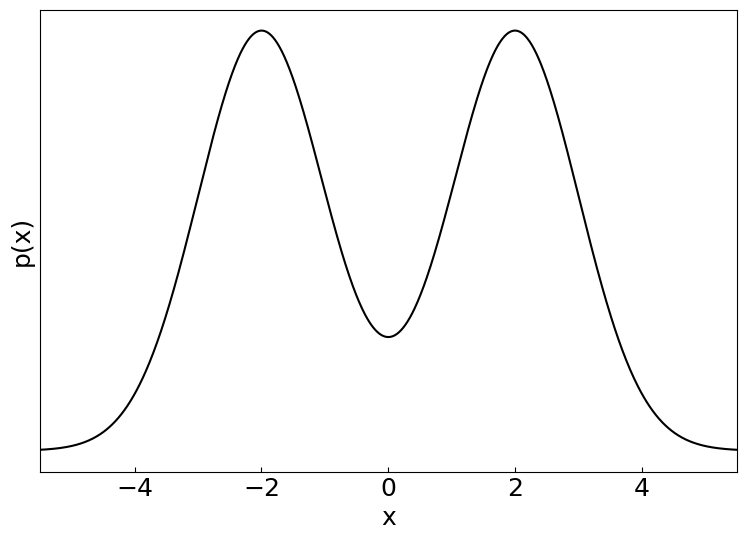

In [95]:
plt.plot(x, y, "k")
plt.yticks([])
plt.xlim(-5.5, 5.5)
plt.ylabel("p(x)")
plt.xlabel("x")
plt.show()

### Metropolis-Hastings

Nous allons d'abord utiliser l'algorithme de Metropolis-Hastings avec une distribution de proposition gaussienne. 

Remarquez que le paramètre `cov` (qui n'est qu'une variance dans ce cas-ci, en 1D) peut être ajusté. Une distribution bimodale est un exemple de cas où il peut être avantageux d'utiliser une covariance un peu plus élevée. Avoir une échelle plus grande permet de plus efficacement se déplacer entre les modes de la distribution. Vous pouvez vous amuser à varier ce paramètres et voir l'effet sur le temps d'autocorrélation.

In [96]:
init = np.random.randn(32, 1)
nwalkers, ndim = init.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob_bimod, moves=emcee.moves.GaussianMove(cov=1.0)
)
sampler.run_mcmc(init, 5000, progress=True)

fchain_gauss = sampler.get_chain(flat=True)

print(f"Temps d'autocorrélation intégré, Metropolis-Hastings: {sampler.get_autocorr_time()}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1692.78it/s]

Temps d'autocorrélation intégré, Metropolis-Hastings: [36.18248028]


On peut ensuite afficher un seul marcheur pour voir les détails de l'échantillonage.

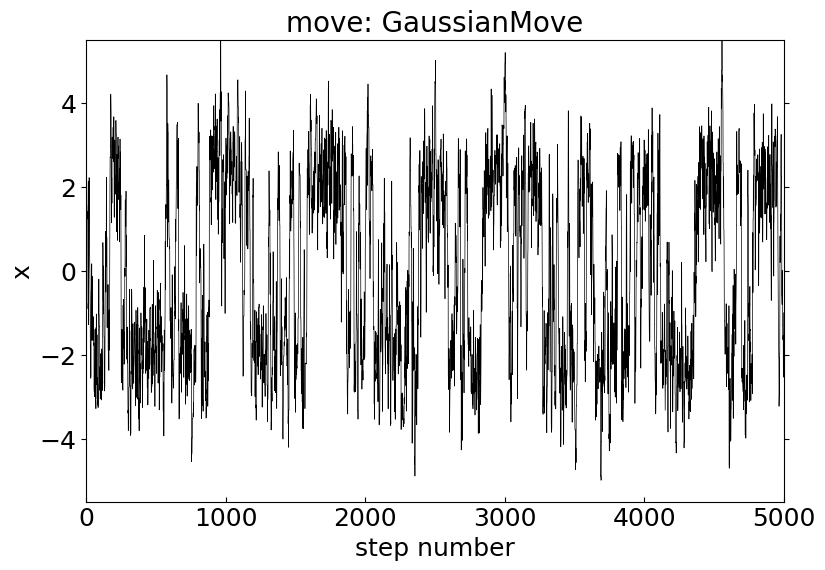

In [97]:
plt.plot(sampler.get_chain()[:, 0, 0], "k", lw=0.5)
plt.xlim(0, 5000)
plt.ylim(-5.5, 5.5)
plt.title("move: GaussianMove", fontsize=20)
plt.xlabel("step number")
plt.ylabel("x")
plt.show()

### "_Stretch Move_" par défaut d'_emcee_

Maintenant, nous pouvons tester le "_stretch move_" d'_emcee_, qui est utilisé par défaut. Il utilise la position des autre marcheurs pour orienter les pas, donc certaines distributions (avec des covariance, par exemple) peuvent être mieux échantillonées.

Comme pour la variance du Metropolis-Hastings, l'échelle `a` pour le "Stretch" peut être ajustée. La valeur par défaut est `a=2.0`. Ici, une valeur de `3.0` semble améliorer l'efficacité (temps d'autocorrélation plus faible).

In [98]:
init = np.random.randn(32, 1)
nwalkers, ndim = init.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob_bimod, moves=emcee.moves.StretchMove(a=3.0)
)
sampler.run_mcmc(init, 5000, progress=True);

fchain_stretch = sampler.get_chain(flat=True)

print(f"Temps d'autocorrélation intégré, Stretch: {sampler.get_autocorr_time()}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1302.51it/s]

Temps d'autocorrélation intégré, Stretch: [21.83729488]


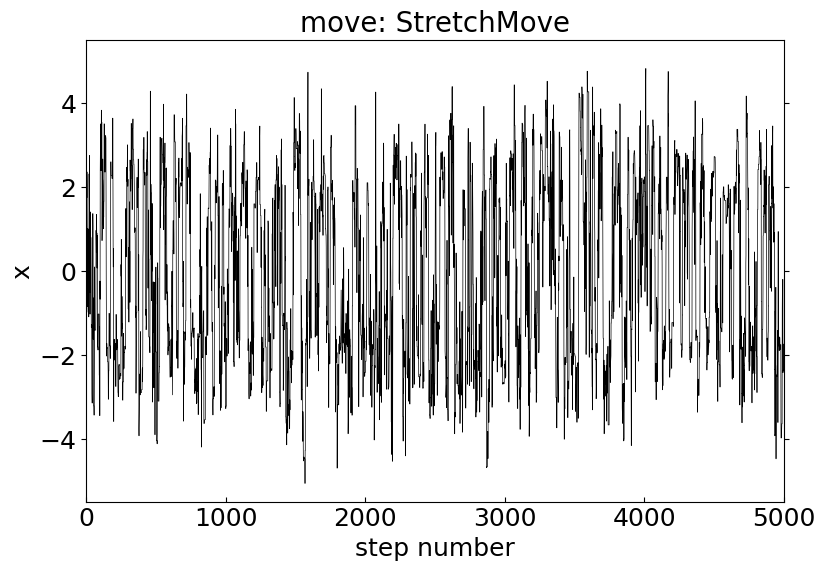

In [99]:
plt.plot(sampler.get_chain()[:, 0, 0], "k", lw=0.5)
plt.xlim(0, 5000)
plt.ylim(-5.5, 5.5)
plt.title("move: StretchMove", fontsize=20)
plt.xlabel("step number")
plt.ylabel("x")
plt.show()

On peut voir ci-dessus que le temps d'autocorrélation est plus court que pour le Metropolis. Donc l'échantillonage est plus efficace (il faudra moins de pas pour atteindre $N \geq \tau_f$).

### MCMC par évolution différentielle

Certaines méthodes pour proposer de nouveaux pas dans _emcee_ utilisent l'évolution différentielle. Je laisse un lien vers la page [Moves](https://emcee.readthedocs.io/en/stable/user/moves/) de la documentation pour les intéressé·e·s. Dans les cas légèrement bimodaux comme celui-ci. le MCMC par évolution différentielle peut être plus efficace.

Il y a deux type de propositions par évolution différentielle (`DEMove()` et `DESnookerMove()`), donc nous allons combiner les deux en tirant 80 % des pas avec le premier et 20 % des pas avec le deuxième.

In [100]:
init = np.random.randn(32, 1)
nwalkers, ndim = init.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_bimod, moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])
sampler.run_mcmc(init, 5000, progress=True)

fchain_de = sampler.get_chain(flat=True)

print(f"Temps d'autocorrélation intégré, DE-MCMC: {sampler.get_autocorr_time()}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 900.25it/s]


Temps d'autocorrélation intégré, DE-MCMC: [6.69444135]


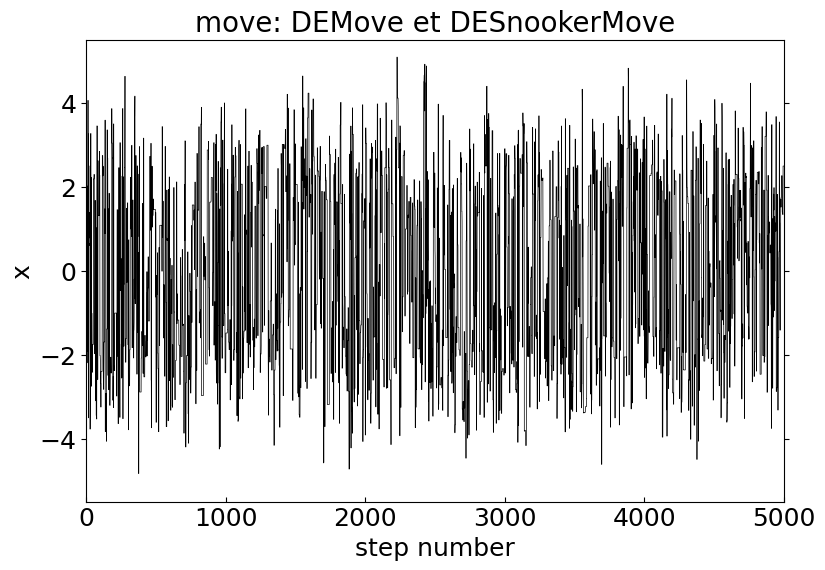

In [101]:
plt.plot(sampler.get_chain()[:, 0, 0], "k", lw=0.5)
plt.xlim(0, 5000)
plt.ylim(-5.5, 5.5)
plt.title("move: DEMove et DESnookerMove", fontsize=20)
plt.xlabel("step number")
plt.ylabel("x")
plt.show()

On voit que le temps d'autocorrélation est beaucoup plus petit que pour les deux premières distributions de proposition. Même à l'oeil, on voit que le marcheur explore plus rapidement.

En général. la configuration par défaut d'_emcee_ (i.e. sans spécifier de `move` au `EnsembleSampler()`) fonctionne très bien. Par contre, si le temps de convergence est très long. Il peut être pertinent de varier les paramètres et le type de pas pour voir l'effet sur la performance du MCMC.

Dans ce cas-ci, on peut voir que les 3 méthodes représentent bien la distribution analytique, malgré leurs différents temps de convergence. Ce ne sera pas toujours le cas avec les distributions à plusieurs dimensions auxquelles nous faisons généralement face en analyse de données.

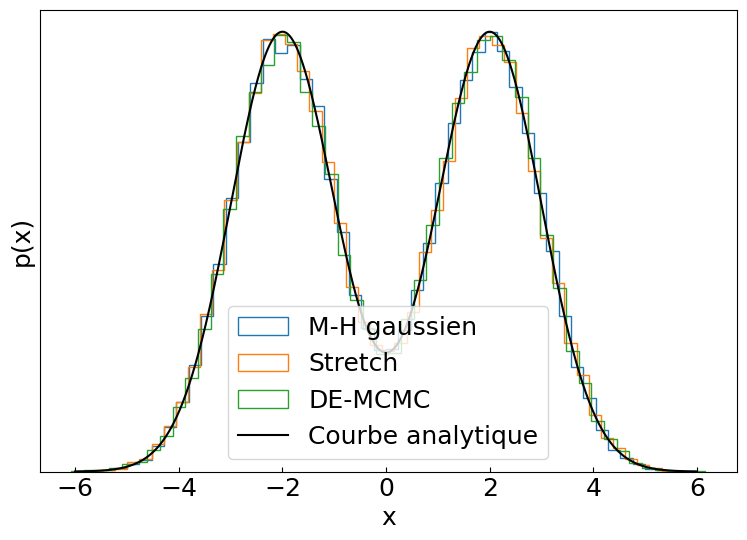

In [102]:
plt.hist(fchain_gauss, bins=50, density=True, histtype="step", label="M-H gaussien")
plt.hist(fchain_stretch, bins=50, density=True, histtype="step", label="Stretch")
plt.hist(fchain_de, bins=50, density=True, histtype="step", label="DE-MCMC")
plt.plot(x, y, "k", label="Courbe analytique")
plt.yticks([])
plt.ylabel("p(x)")
plt.xlabel("x")
plt.legend()
plt.show()